In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import sklearn
#print(sklearn.__version__)

In [ ]:
### Read all the domcuments artribute types as required ###
### Change File Location as needed ###
CS_DS = pd.read_csv("C:/Users/USER/5. SCG/preML_v5b_010622.csv",
                     dtype={"tax_id": str, "cust_name": str,"mind_sect": str, "input1_tax_id": str
                            #"max_overdue_days": float,                          
                           })

In [3]:
#CS_DS.head()

In [4]:
### Drop Columns that won't be used in machine learning algorithm ###
CS_DS2 = CS_DS.drop(columns=['tax_id','cust_name','mind_sect','input1_tax_id','class_max'])
#CS_DS2

In [5]:
### Data Profile for Input Data ###
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
describer = CS_DS2.describe(percentiles = [.5]).T
list1 = np.count_nonzero(CS_DS2, axis=0).tolist()
describer['non_zeros'] = list1
describer['Name'] = describer.index

describer = describer[['Name','count','mean','std','min','50%','max','non_zeros']]
#describer

## Modeling

In [6]:
### Cross-Validation [Stratified K-Fold] ###
from statistics import mean, stdev
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
### Separate Data into inputs vs desired output
#X = CS_DS2.iloc[:, 0:122].values
#y = CS_DS2.iloc[:, 122].values
X = CS_DS2.drop(['class_max_binary'], axis = 'columns').values #Train set
y = CS_DS2.class_max_binary.values#Test set
#X
#y

In [7]:
### Default Random Forest Settings
GB_model = GradientBoostingClassifier()
### USE PARAMETERS FROM RANDOMSEARCH HERE
#RF_model = RandomForestClassifier(n_estimators=300,
    #min_samples_split=5,min_samples_leaf=5,max_features='sqrt',max_depth=40,bootstrap=True)

### Split input and output into training and hidden(testing) data
X_train, X_hidden, y_train, y_hidden = train_test_split(X, y, stratify=y, test_size=0.15,random_state=0)
#print(X_train.shape, X_hidden.shape)
#print(y_train.shape, y_hidden.shape)

#### StratifiedKFold - Cross validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

### Manual stratified k-fold cross-validation
skf = StratifiedKFold(n_splits = 10)
lst_B_accu_stratified = []
lst_accu_stratified = []

for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    GB_model.fit(x_train_fold, y_train_fold) 
    #Without Kfold, will be RF_model.fit(X_train, y_train)
    y_pred_fold = GB_model.predict(x_test_fold)
    
    lst_accu_stratified.append(accuracy_score(y_test_fold, y_pred_fold))
    lst_B_accu_stratified.append(balanced_accuracy_score(y_test_fold,y_pred_fold))

### Cross-Validation Evaluation [Evaluated against validation sets not hidden set]     
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_B_accu_stratified)*100, '%')
print('\nMinimum Balanced Accuracy:',
      min(lst_B_accu_stratified)*100, '%')
print('\nOverall Balanced Accuracy:',
      mean(lst_B_accu_stratified)*100, '%')
print('==================================')
print('Length Check')
print('full_data',len(X),len(y))
print('training',len(X_train),len(y_train))
print('Hidden',len(X_hidden),len(y_hidden))
print('folds','train',len(x_train_fold),len(y_train_fold),'test',len(x_test_fold),len(y_test_fold))


Maximum Balanced Accuracy That can be obtained from this model is: 83.13725490196079 %

Minimum Balanced Accuracy: 69.28571428571428 %

Overall Balanced Accuracy: 75.48419913419913 %
Length Check
full_data 1244 1244
training 1057 1057
Hidden 187 187
folds train 952 952 test 105 105


## Model Evaluations
- Confusion matrix
- accuracy score
- ROC
- Precision_Recall

In [10]:
### Model Evaluation [Evaluated against Hidden Test Set / test set {Unseen Data}] ###
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score)
from sklearn.metrics import (roc_auc_score, plot_roc_curve, roc_curve, precision_recall_curve,plot_precision_recall_curve,average_precision_score, 
                             PrecisionRecallDisplay)

y_pred_train = GB_model.predict(X_train)
y_pred_hidden = GB_model.predict(X_hidden)

print("==== TRAINING ====")
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print("balanced accuracy:",balanced_accuracy_score(y_train,y_pred_train))

print("\n==== HIDDEN ====\n")
print(confusion_matrix(y_hidden,y_pred_hidden))
print(classification_report(y_hidden,y_pred_hidden))
print("Balanced Accuracy:",balanced_accuracy_score(y_hidden,y_pred_hidden))

print("ROC AUC Score:",roc_auc_score(y_hidden,GB_model.predict_proba(X_hidden)[:, 1]))

print("Average Precision Score:",average_precision_score(y_hidden,GB_model.predict_proba(X_hidden)[:, 1]))

==== TRAINING ====
[[452  51]
 [ 53 501]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       503
           1       0.91      0.90      0.91       554

    accuracy                           0.90      1057
   macro avg       0.90      0.90      0.90      1057
weighted avg       0.90      0.90      0.90      1057

balanced accuracy: 0.9014702399322476

==== HIDDEN ====

[[60 29]
 [26 72]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69        89
           1       0.71      0.73      0.72        98

    accuracy                           0.71       187
   macro avg       0.71      0.70      0.70       187
weighted avg       0.71      0.71      0.71       187

Balanced Accuracy: 0.7044255904609035
ROC AUC Score: 0.784682412290759
Average Precision Score: 0.7852411635635357


## Feature Importance

Text(0.5, 1.0, 'Feature Importance (MDI)')

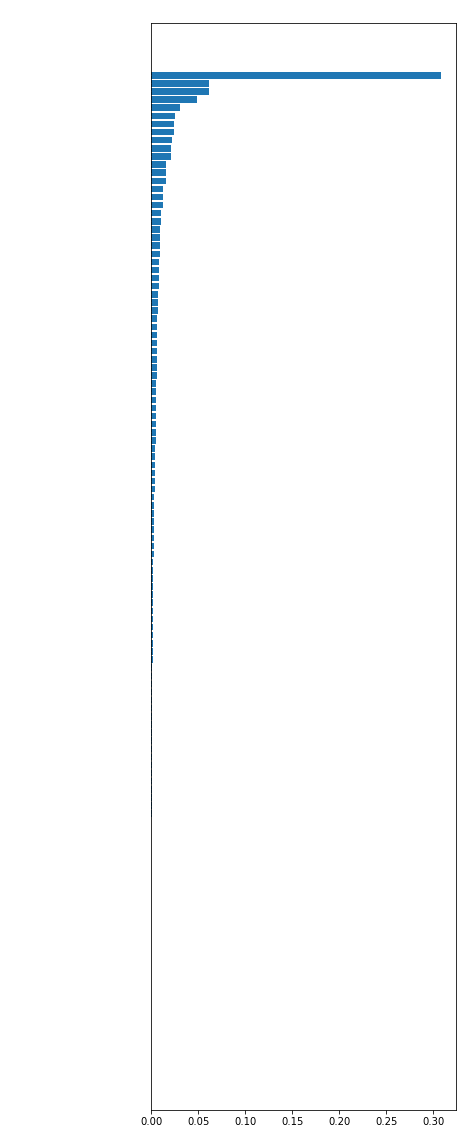

In [11]:
### Feature Importance Asessment [from Random Forest]
feature_importance= GB_model.feature_importances_
#feature_importance= grid_RF_test.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 20))
feature_names = CS_DS2.columns.tolist()

### Change plot settings as required ###
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.tick_params(axis='y', colors='white')
plt.title("Feature Importance (MDI)", color = 'white')
#sorted_idx
#feature_names

## Hyper parameter selection

In [12]:
#### HYPER PARAMETER SELECTION [Randomized CV Search] ####
def param(score_type):
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import roc_auc_score
    
    # Number of trees in random forest
    #n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    
    #n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    # Number of features to consider at every split
    
    #max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    
    #max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    #max_depth.append(None)
    
    # Minimum number of samples required to split a node
    #min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    # Minimum number of samples required at each leaf node
    #min_samples_leaf = [1, 2, 3, 4, 5, 6]
    
    # Method of selecting samples for training each tree
    #bootstrap = [True]
    #bootstrap = [True, False]
    
    #Gradient Boosting parameters;
    #learning_rate=0.005, n_estimators=1500,  max_depth=9,    min_samples_split=1200,    min_samples_leaf=60, 
    #subsample=0.85,      random_state=10,    max_features=7,  warm_start=True
    learning_rate = [0.01,0.1,1,10,100]
    n_estimators = [5, 50, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
    max_depth = [1,3,5,7,9]
    max_features = ['auto', 'sqrt']
    #min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    #min_samples_leaf = [1, 2, 3, 4, 5, 6]
    
    # Create the random grid
    random_grid = {'learning_rate' : learning_rate,
                   'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'max_features': max_features
                   #,'min_samples_split': min_samples_split,
                   #'min_samples_leaf': min_samples_leaf,
                   #'bootstrap': bootstrap
                  }
    print(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    #GB_Model
    # Random search of parameters, using 3 fold cross validation or change to desried k value, 
    # search across 100 different combinations, and use all available cores
    GB_random = RandomizedSearchCV(estimator = GB_model, scoring =score_type, 
                param_distributions = random_grid, n_iter = 100, cv = 3, 
                verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    GB_random.fit(X_train, y_train)

    print(score_type,"\n",GB_random.best_params_)
    best_random = GB_random.best_estimator_
    print("ROC AUC Score:",roc_auc_score(y_hidden,GB_random.predict_proba(X_hidden)[:, 1]))
    print("ROC AUC Score:",roc_auc_score(y_hidden,best_random.predict_proba(X_hidden)[:, 1]))

#param('balanced_accuracy')
param('roc_auc')
#param('average_precision')

### SEE IF ROC_AUC SCORE HAS IMPROVED OR NOT ###

{'learning_rate': [0.01, 0.1, 1, 10, 100], 'n_estimators': [5, 50, 200, 400, 600, 800, 1000, 1200, 1400, 1600], 'max_depth': [1, 3, 5, 7, 9], 'max_features': ['auto', 'sqrt']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.8min finished


roc_auc 
 {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.01}
ROC AUC Score: 0.8008484292593442
ROC AUC Score: 0.8008484292593442


In [14]:
### MODEL EVALUATION OF Settings from Randomized Search ###

### USE PARAMETERS FROM RANDOMSEARCH HERE
GB_model2 = GradientBoostingClassifier(learning_rate = 0.01,
                                       n_estimators = 400,
                                       max_depth = 3,
                                       max_features ='sqrt')

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             balanced_accuracy_score)
from sklearn.metrics import (roc_auc_score, plot_roc_curve, roc_curve, precision_recall_curve, 
                             plot_precision_recall_curve,average_precision_score, 
                             PrecisionRecallDisplay)

GB_model2.fit(X_train, y_train)
y_pred_train = GB_model2.predict(X_train)
y_pred_hidden = GB_model2.predict(X_hidden)

print("==== TRAINING ====")
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print("balanced accuracy:",balanced_accuracy_score(y_train,y_pred_train))
print("\n==== HIDDEN ====\n")
print(confusion_matrix(y_hidden,y_pred_hidden))
print(classification_report(y_hidden,y_pred_hidden))
print("Balanced Accuracy:",balanced_accuracy_score(y_hidden,y_pred_hidden))
print("ROC AUC Score:",roc_auc_score(y_hidden,GB_model2.predict_proba(X_hidden)[:, 1]))
print("Average Precision Score:",average_precision_score(y_hidden,GB_model2.predict_proba(X_hidden)[:, 1]))


==== TRAINING ====
[[421  82]
 [ 90 464]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       503
           1       0.85      0.84      0.84       554

    accuracy                           0.84      1057
   macro avg       0.84      0.84      0.84      1057
weighted avg       0.84      0.84      0.84      1057

balanced accuracy: 0.8372616287832572

==== HIDDEN ====

[[64 25]
 [27 71]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        89
           1       0.74      0.72      0.73        98

    accuracy                           0.72       187
   macro avg       0.72      0.72      0.72       187
weighted avg       0.72      0.72      0.72       187

Balanced Accuracy: 0.7217954597569365
ROC AUC Score: 0.8030268287090118
Average Precision Score: 0.8086486109926456
